In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import datetime
from datetime import timedelta
import seaborn as sns

#### Dane ze strony https://www.citibikenyc.com/system-data pochodzące z systemu wypożyczania rowerów dla Nowego Jorku

In [5]:
filenames = glob.glob('*.csv')
filenames[-12:]

['201906-citibike-tripdata.csv',
 '201907-citibike-tripdata.csv',
 '201908-citibike-tripdata.csv',
 '201909-citibike-tripdata.csv',
 '201910-citibike-tripdata.csv',
 '201911-citibike-tripdata.csv',
 '201912-citibike-tripdata.csv',
 '202001-citibike-tripdata.csv',
 '202002-citibike-tripdata.csv',
 '202003-citibike-tripdata.csv',
 '202004-citibike-tripdata.csv',
 '202005-citibike-tripdata.csv']

Ładowanie danych z ostatnich 2 lat, jeden miesiąc (june2k18) posłuży mi do szybkiego sprawdzania wyników funkcji / tego jak wyglądają tworzone wykresy przed zaaplikowaniem dla dużych danych

In [6]:
all_data = [pd.read_csv(f) for f in filenames[-24:]]

In [10]:
june2k18 = all_data[0]
june2k18.head(5)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,569,2018-06-01 01:57:20.5140,2018-06-01 02:06:50.0880,72,W 52 St & 11 Ave,40.767272,-73.993929,173,Broadway & W 49 St,40.760683,-73.984527,21481,Subscriber,1999,1
1,480,2018-06-01 02:02:42.3980,2018-06-01 02:10:43.3540,72,W 52 St & 11 Ave,40.767272,-73.993929,477,W 41 St & 8 Ave,40.756405,-73.990026,19123,Subscriber,1988,1
2,692,2018-06-01 02:04:23.6240,2018-06-01 02:15:55.7470,72,W 52 St & 11 Ave,40.767272,-73.993929,457,Broadway & W 58 St,40.766953,-73.981693,26983,Subscriber,1986,1
3,664,2018-06-01 03:00:55.4610,2018-06-01 03:11:59.9060,72,W 52 St & 11 Ave,40.767272,-73.993929,379,W 31 St & 7 Ave,40.749156,-73.991600,26742,Subscriber,1973,1
4,818,2018-06-01 06:04:54.4270,2018-06-01 06:18:32.6170,72,W 52 St & 11 Ave,40.767272,-73.993929,459,W 20 St & 11 Ave,40.746745,-74.007756,26386,Subscriber,1984,1


## Wiek i płeć

In [11]:
age_info = pd.concat([df[["birth year", "gender"]] for df in all_data], ignore_index=True)
age_info

,birth year,gender
0,1999,1
1,1988,1
2,1986,1
3,1973,1
4,1984,1
...,...,...
38055533,1972,2
38055534,1994,2
38055535,1998,1
38055536,1969,0


In [256]:
#june2k18.starttime = june2k19.starttime.astype(dtype='datetime64')
#june2k18.stoptime = june2k19.stoptime.astype(dtype='datetime64')
#june2k18["dayofweek"] = june2k19.starttime.apply(lambda a: a.day_name())

In [12]:
age_info["age"] = datetime.datetime.now().year - age_info["birth year"]

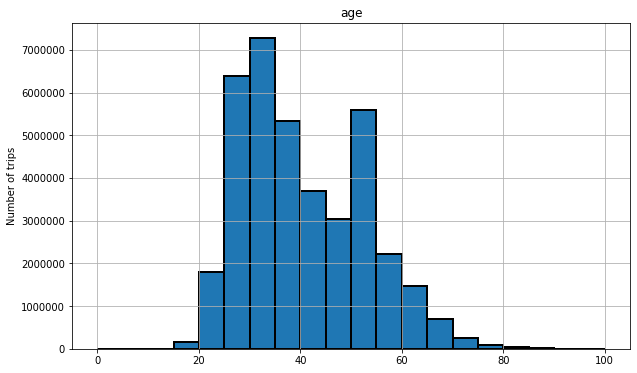

In [13]:
hist = age_info.hist(column = "age", bins=[i for i in range(0,101,5)],edgecolor='black',linewidth=2, figsize=(10,6))
plt.ylabel("Number of trips")
plt.show()

Dla wieku = 51 widać nienaturalnie wysoką liczbę przejazdów. Prawdopodobnie w aplikacji rok 1969 jest wartością domyślną dla roku urodzenia i część osób jej nie zmienia bo nie chce podawać swoich prawdziwych danych.

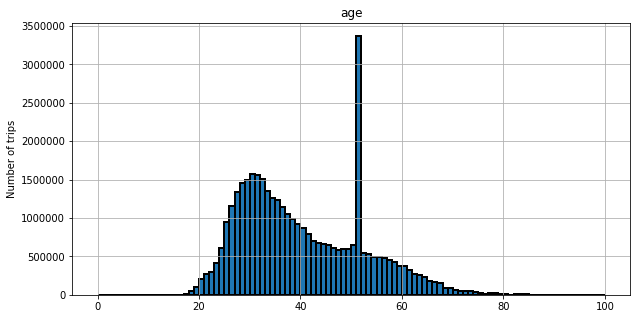

In [14]:
age_info.hist(column = "age", bins=[i for i in range(0,101,1)],edgecolor='black',linewidth=2, figsize=(10,5))
plt.ylabel("Number of trips")
plt.show()

In [15]:
print(age_info["age"].value_counts())

51     3370538
30     1577591
31     1566085
32     1512322
29     1499592
        ...   
122          3
115          2
157          2
117          1
140          1
Name: age, Length: 121, dtype: int64


Odrzucamy tyle rekordów dla wieku = 51, aby przejazdów było tyle samo co dla osób w wieku 50 lat.

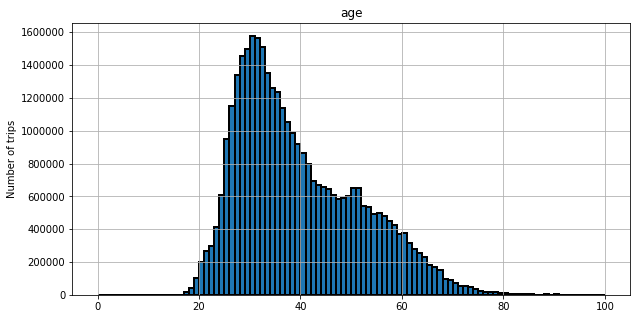

In [16]:
drop_number = age_info["age"].value_counts().loc[51] -age_info["age"].value_counts().loc[50]
drop_indices = np.random.choice(age_info[(age_info.age == 51)].index, drop_number, replace=False)
age_info_corrected = age_info.drop(drop_indices)
age_info_corrected.hist(column = "age", bins=[i for i in range(0,101,1)],edgecolor='black',linewidth=2, figsize=(10,5))
plt.ylabel("Number of trips")
plt.show()

In [17]:
print(age_info_corrected[age_info_corrected["age"] <10].shape[0])
print(age_info_corrected[age_info_corrected["age"] >100].shape[0])

0
19520


In [18]:
age_info_corrected["age_group"] = pd.cut(age_info_corrected.age, [i for i in range(10,101,15)],
                               right=False, labels=["{} - {}".format(i, i+14) for i in range(10,100,15)])

In [19]:
age_info_corrected["gender"] = age_info_corrected["gender"].astype(dtype='category')
age_info_corrected["gender"] = age_info_corrected["gender"].cat.rename_categories(['unknown', 'male', 'female'])
age_info_corrected["gender"].value_counts()

male       25406616
female      9111355
unknown      815969
Name: gender, dtype: int64

In [20]:
x = age_info_corrected.groupby(["age_group", "gender"]).size().unstack()
x

gender,unknown,male,female
age_group,,,
10 - 24,17397,1381123,552297
25 - 39,164257,13551320,5286782
40 - 54,609600,6876018,2106312
55 - 69,18425,3294237,1067868
70 - 84,2614,284853,88759
85 - 99,323,6133,6063


Text(0, 0.5, 'Number of trips')

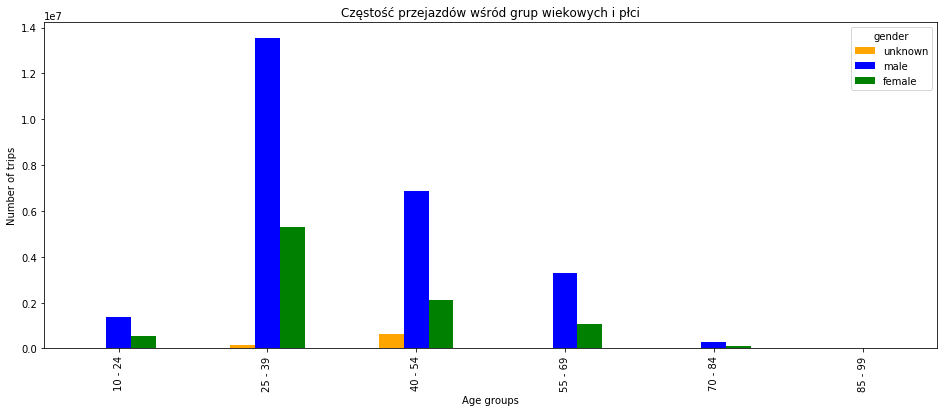

In [21]:
x.plot(kind="bar", color=["orange", "blue", "green"], figsize=(16,6), title='Częstość przejazdów wśród grup wiekowych i płci')
plt.xlabel("Age groups")
plt.ylabel("Number of trips")

In [23]:
age_info_corrected.groupby(["age_group", "gender"]).size().unstack().to_csv("processed_data/number_of_trips_in_age_groups.csv")

## Rowery

Sprawdzimy czy rowery są w podobnym stopniu eksploatowane, czy może niewielka liczba sztuk krąży między najbardziej uczęszczanymi stacjami. Jeżeli tak się dzieje to być może warto je obserwować czy nie wymagają serwisu.

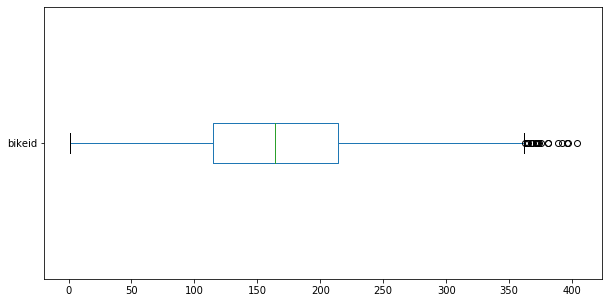

In [29]:
june2k18["bikeid"].value_counts().quantile(np.linspace(0.0, 1.0, num=21))
june2k18["bikeid"].value_counts().plot.box(figsize=(10,5), vert=False)

In [30]:
bikeidDF = pd.concat([df["bikeid"] for df in all_data], ignore_index=True)
usage_of_bikes = pd.DataFrame(bikeidDF.value_counts())
usage_of_bikes.index.name = "bikeid"
usage_of_bikes.columns=["number_of_trips"]
usage_of_bikes.to_csv("processed_data/usage_of_bikes_last_2_years.csv")

bikeidDF.value_counts().quantile(np.linspace(0.0, 1.0, num=21))

0.00       1.0
0.05     191.0
0.10     304.0
0.15     448.5
0.20     830.0
0.25    1119.0
0.30    1243.0
0.35    1339.5
0.40    1463.0
0.45    1615.0
0.50    1737.0
0.55    1839.0
0.60    1931.0
0.65    2017.0
0.70    2107.0
0.75    2221.0
0.80    2413.0
0.85    2722.5
0.90    3103.0
0.95    3482.5
1.00    5360.0
Name: bikeid, dtype: float64

95% rowerów była użyta 3482 lub mniej razy, ale są też rowery używane więcej niż 5000 razy

Text(0.5, 0, 'Liczba przejazdów')

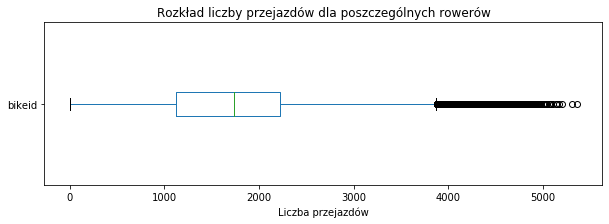

In [31]:
bikeidDF.value_counts().plot.box(figsize=(10,3), vert=False, title="Rozkład liczby przejazdów dla poszczególnych rowerów")

plt.xlabel("Liczba przejazdów")

In [32]:
Q1 = usage_of_bikes.number_of_trips.quantile(0.25)
Q3 = usage_of_bikes.number_of_trips.quantile(0.75)
IQR = Q3 - Q1

In [33]:
outliers = usage_of_bikes[usage_of_bikes.number_of_trips > (Q3 + 1.5*IQR)]
outliers

,number_of_trips
bikeid,
34187,5360
33877,5311
33800,5201
34000,5172
34088,5152
...,...
35378,3881
33796,3881
34299,3879


## Goście a subskrybenci

Sprawdzimy w którym miesiącu ostatniego roku było stosunkowo najwięcej klientów z biletem krótkookresowym. Być może w te miesiące warto zainwestować w reklamę i rozdawać kody promocyjne na karnety.

In [42]:
usertypeDF = pd.concat([pd.DataFrame({'usertype_count' : df.groupby(["usertype"]).size(),
              'month' : df.groupby(["usertype"]).first()["starttime"]}) for df in all_data[-12:]])

In [43]:
usertypeDF.month = usertypeDF.month.astype('datetime64')
usertypeDF.month = usertypeDF.month.apply(lambda datetime: datetime.month_name())

In [44]:
usertypeDF

,usertype_count,month
usertype,,
Customer,372844,June
Subscriber,1752526,June
Customer,378009,July
Subscriber,1803055,July
Customer,443865,August
Subscriber,1900359,August
Customer,434407,September
Subscriber,2010493,September
Customer,295753,October


In [45]:
usertypeDF = usertypeDF.merge(usertypeDF.groupby(['month']).sum(), on=['month'], suffixes=('', '_combined'), right_index=True)
usertypeDF['group_in_month_ratio'] = usertypeDF.loc[:].values[:,0]/usertypeDF.loc[:].values[:,2]
usertypeDF

,usertype_count,month,usertype_count_combined,group_in_month_ratio
usertype,,,,
Customer,372844,June,2125370,0.175425
Subscriber,1752526,June,2125370,0.824575
Customer,378009,July,2181064,0.173314
Subscriber,1803055,July,2181064,0.826686
Customer,443865,August,2344224,0.189344
Subscriber,1900359,August,2344224,0.810656
Customer,434407,September,2444900,0.177679
Subscriber,2010493,September,2444900,0.822321
Customer,295753,October,2092573,0.141335


In [46]:
usertypeDF.to_csv("processed_data/ratio_of_subscribers_last_year.csv")

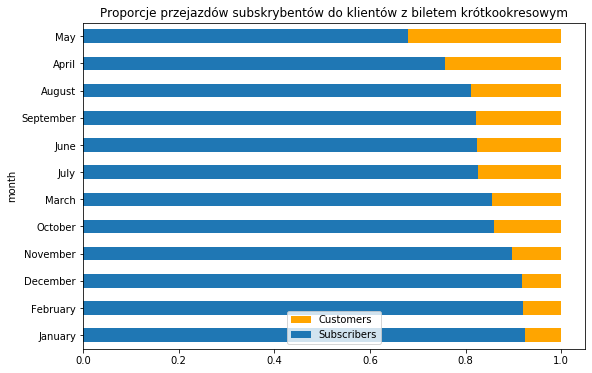

In [47]:
usertypeDF['ones'] = usertypeDF['usertype_count_combined']/usertypeDF['usertype_count_combined']

ax = usertypeDF.loc['Subscriber'].plot(kind='barh', x = 'month', y='ones', color ='orange')
usertypeDF.loc['Subscriber'].sort_values(['group_in_month_ratio'], ascending=False).plot(kind='barh', x = 'month', y='group_in_month_ratio',
                                                               ax = ax, figsize=(9,6), title='Proporcje przejazdów subskrybentów do klientów z biletem krótkookresowym').legend(loc='lower center', labels=('Customers', 'Subscribers'))


## Stacje przy których jest najwięcej customerów

Wyszukamy stancje przy których najczęściej wypożyczali użytkownicy z bieltem krótkookresowym, czyli gdzie można znaleźć potencjalnych 

In [48]:
places_attended_by_customers = pd.concat([df[['start station id', 'start station name']][df['usertype'] == 'Customer'] for df in all_data])

In [49]:
places_attended_by_customers['start station id'].value_counts()

2006.0    75156
281.0     62366
3282.0    55971
514.0     53992
387.0     51678
          ...  
3488.0        1
3912.0        1
3947.0        1
3941.0        1
3957.0        1
Name: start station id, Length: 1015, dtype: int64

Text(0.5, 0, 'Liczba wypożyczeń w danym punkcie przez użytkowników z biletem krótkookresowym')

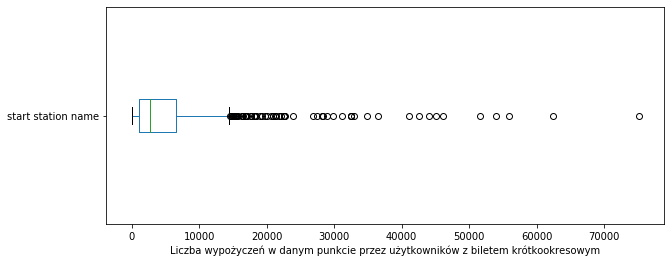

In [50]:
attendance_of_customers = places_attended_by_customers['start station name'].value_counts()
attendance_of_customers.T.plot.box(figsize=(10,4), vert=False)
plt.xlabel("Liczba wypożyczeń w danym punkcie przez użytkowników z biletem krótkookresowym")

In [51]:
df = pd.DataFrame({'start station name' : attendance_of_customers.index, 'number_of_customers': attendance_of_customers.values})

In [52]:
df.to_csv("processed_data/places_attended_by_customers.csv")

In [53]:
Q1 = df.number_of_customers.quantile(0.25)
Q3 = df.number_of_customers.quantile(0.75)
IQR = Q3-Q1

outliers = df[df.number_of_customers > Q3+1.5*IQR]

In [54]:
outliers

,start station name,number_of_customers
0,Central Park S & 6 Ave,75156
1,Grand Army Plaza & Central Park S,62366
2,5 Ave & E 88 St,55971
3,12 Ave & W 40 St,53992
4,Centre St & Chambers St,51678
...,...,...
64,Broadway & W 29 St,15017
65,11 Ave & W 41 St,14968
66,W 33 St & 7 Ave,14964
67,Allen St & Stanton St,14726
